# Details
Aparna Ambarapu
Student ID: 12457994

# Download datasets
Downloading and loading relevant datasets - and deciding our period for trading
- IUDSOIA (Daily overnight index swap curve)
- EDI/CUR tables API database for all FX rates
- swap rate data from the InferredYieldCurves


In [1]:
import os
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import plotnine as p9
import quandl
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from functools import reduce
from scipy.stats import zscore
import statsmodels.api as sm
import sys
sys.path.append('/Users/aparnaambarapu/Downloads/qts/HW')
import scipy.interpolate as spi

from quandl_data_load import api_key

In [2]:
folder_path = '/Users/aparnaambarapu/Downloads/qts/HW/HW5'
quandl.ApiConfig.api_key = api_key

In [50]:
def get_date_summary(df_list, col_name='code'):
    summary = []
    for df in df_list.values():
        dates = pd.to_datetime(df.index).sort_values().drop_duplicates()
        min_date = dates.min()
        max_date = dates.max()
        if len(dates) > 1:
            gaps = dates.to_series().diff().dropna()
            max_gap_idx = gaps.argmax()  # Get index of max gap
            max_gap = gaps.iloc[max_gap_idx].days
            dates_list = dates.tolist()
            max_gap_start = dates_list[max_gap_idx]  # Start of max gap
            max_gap_end = dates_list[max_gap_idx + 1]  # End of max gap
        else:
            max_gap = 0
            max_gap_start, max_gap_end = None, None
        summary.append({
            'DataFrame': df[col_name].iloc[0],
            'Min Date': min_date.date() if not pd.isnull(min_date) else None,
            'Max Date': max_date.date() if not pd.isnull(max_date) else None,
            'Max Gap (Days)': max_gap,
            'Max Gap Start': max_gap_start.date() if max_gap_start else None,
            'Max Gap End': max_gap_end.date() if max_gap_end else None,
            'Total Days': len(dates)
        })
    return pd.DataFrame(summary).set_index('DataFrame')

def forward_fill_fx_rates(df_list, start_date, end_date, col_name='code'):
    full_index = pd.date_range(start=start_date, end=end_date, freq='D')
    processed_dfs = {}
    for k, df in df_list.items():
        clean_df = (df
            .assign(
                code=lambda x: x[col_name].ffill(),
                rate=lambda x: pd.to_numeric(x['rate'], errors='coerce'))
            .resample('D').last())
        filled_df = (
            clean_df
            .reindex(full_index)
            .pipe(lambda x: x.ffill().bfill()))
        processed_dfs.update({k:filled_df})
    return processed_dfs

def plot_fx_rates(fx_dfs):
    combined_df = pd.concat([
        df.assign(currency=df['code'].iloc[0]) for df in fx_dfs.values()])

    fx_plot = (
        p9.ggplot(combined_df.reset_index(), p9.aes(x='index', y='rate'))  # Use index as x-axis
        + p9.geom_line(color='steelblue', size=0.7)
        + p9.facet_wrap('~ currency', ncol=2, scales='free_y')
        + p9.labs(
            title='Daily FX Rates by Currency vs USD',
            x='Date',
            y='Exchange Rate'
        )
        + p9.theme(
            figure_size=(12, 8),
            axis_text_x=p9.element_text(rotation=45, hjust=1),
            strip_background=p9.element_rect(fill='#f0f0f0'),
            subplots_adjust={'hspace': 0.35, 'wspace': 0.2}
        )
        + p9.scale_x_datetime(date_labels='%Y', date_breaks='2 years')
    )
    return fx_plot

def plot_yield_curves(df_list, col_name='shortname'):
    combined_df = pd.concat([
        df.assign(currency=df[col_name].iloc[0])
        for df in df_list.values()])
    combined_df = combined_df.reset_index().rename(columns={'index': 'date'})
    combined_df['date'] = pd.to_datetime(combined_df['date'])
    combined_df['yield'] = pd.to_numeric(combined_df['yield'], errors='coerce')
    combined_df['tenor'] = combined_df['tenor'].astype(str)
    if combined_df.empty or combined_df['yield'].isna().all():
        raise ValueError("DataFrame is empty or contains only NaN values in 'yield'.")
    yield_curve_plot = (
        p9.ggplot(combined_df, p9.aes(x='date', y='yield', color='tenor'))
        + p9.geom_line(size=0.7)
        + p9.facet_grid('currency ~ .', scales='free_y', labeller=p9.as_labeller(lambda x: f"Currency: {x}"))  # Add currency name
        + p9.labs(
            title='Yield Curve Evolution by Currency',
            x='Date',
            y='Yield (%)',
            color='Tenor')
        + p9.theme(
            figure_size=(10, len(df_list) * 3),
            axis_text_x=p9.element_text(rotation=45, hjust=1),
            strip_background=p9.element_rect(fill='#f0f0f0'),
            strip_text=p9.element_text(size=12, weight='bold'),
            subplots_adjust={'hspace': 0.5})
        + p9.scale_x_datetime(date_labels='%Y', date_breaks='2 years'))
    return yield_curve_plot

def convert_tenor(tenor):
    if tenor.endswith("Y"):
        return float(tenor[:-1])
    elif tenor.endswith("M"):
        return float(tenor[:-1]) / 12
    elif tenor.endswith("D"):
        return float(tenor[:-1]) / 365
    return float(tenor)


def process_swap_rates(df_list, min_date, max_date):
    processed_dfs = {}
    full_index = pd.date_range(start=min_date, end=max_date, freq='D')
    for k, df in df_list.items():
        df = df.copy()
        df.index = pd.to_datetime(df.index)
        df = df.sort_index()

        pivot_df = df.pivot_table(index=df.index, columns='tenor', values='yield', aggfunc='first')
        pivot_df.columns = [convert_tenor(tenor) for tenor in pivot_df.columns]

        pivot_df = pivot_df.reindex(full_index)
        pivot_df[0.0] = pivot_df[0.5]/2
        pivot_df = pivot_df[sorted(pivot_df.columns)]
        pivot_df.ffill(inplace=True)
        processed_dfs[k] = pivot_df
    return processed_dfs

def plot_swap_rate_correlation_subplots(swap_rates_dict):
    tenors = [0.5, 1, 5, 10]
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i, tenor in enumerate(tenors):
        tenor_df = pd.concat({k: v[tenor] for k, v in swap_rates_dict.items()}, axis=1)
        correlation_matrix = tenor_df.corr()
        sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, ax=axes[i])
        axes[i].set_title(f"{tenor}Y Swap Rates")
    plt.tight_layout()
    plt.show()

# from Zero_And_Spot_Curves.ipynb
def bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor, 0, step=-0.25)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.25 * coupon_rate * np.exp(-r*times).sum()
    return p

def compute_zcb_curve(spot_rates_curve):
    spot_rates_curve = spot_rates_curve.T
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.items():
            if tenor > 0.001:
                times = np.arange(tenor - 0.25, 0, step=-0.25)[::-1]
                coupon_half_yr = 0.25 * spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values)  # Linear interpolation
                preceding_coupons_val = (coupon_half_yr * np.exp(-z * times)).sum()
                zcb_rates[curve][tenor] = -np.log((1 - preceding_coupons_val) / (1 + coupon_half_yr)) / tenor
    return zcb_rates.T

def plot_zero_curve_vs_swap_rates_by_tenor(currency, zero_curve_list, processed_swap_dfs):
    if currency in zero_curve_list and currency in processed_swap_dfs:
        tenors = sorted([t for t in processed_swap_dfs[currency].columns if t > 0])  # Ignore index 0 (0D)
        fig, axes = plt.subplots(nrows=len(tenors), figsize=(10, 5 * len(tenors)))

        if len(tenors) == 1:
            axes = [axes]  # Ensure it's iterable

        for ax, tenor in zip(axes, tenors):
            ax.plot(
                zero_curve_list[currency].index,
                zero_curve_list[currency][tenor],
                label=f'Zero Curve {tenor}Y',
                linestyle='-',
            )

            ax.plot(
                processed_swap_dfs[currency].index,
                processed_swap_dfs[currency][tenor],
                label=f'Swap Rate {tenor}Y',
                linestyle='--'
            )
            ax.set_title(f"Zero Curve vs Swap Rate ({currency}, {tenor}Y)")
            ax.set_xlabel("Date")
            ax.set_ylabel("Rate")
            ax.legend()
            ax.grid()
        plt.tight_layout()
        plt.show()
    else:
        print(f"{currency} data not found in either zero_curve_list or processed_swap_dfs.")

def plot_correlation_heatmap(swap_curves, zero_curves):
    swap_df = pd.concat(swap_curves, axis=1, keys=swap_curves.keys())
    zero_df = pd.concat(zero_curves, axis=1, keys=zero_curves.keys())
    combined_df = pd.concat([swap_df, zero_df], axis=1)
    correlation_matrix = combined_df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title("Correlation Heatmap of Swap and Zero Curves")
    plt.show()

## FX rates

In [4]:
start_date = '2010-01-01'
end_date = '2025-01-31'
currencies_data = quandl.get_table(
    'EDI/CUR',
    code = ['TRY', 'PKR', 'CRC', 'ZAR', 'GBP'],
    date={'gte': start_date, 'lte': end_date},
    paginate=True
).sort_values(by='date').set_index('date')

In [5]:
gbp_fx_df = currencies_data[currencies_data.code == 'GBP'] # British pound sterling
try_fx_df = currencies_data[currencies_data.code == 'TRY'] # Turkish Lira
pkr_fx_df = currencies_data[currencies_data.code == 'PKR'] # Pakistani Rupee
crc_fx_df = currencies_data[currencies_data.code == 'CRC'] # Costa Rican Colón
zar_fx_df = currencies_data[currencies_data.code == 'ZAR'] # South African Rand

In [6]:
fx_dfs = {'TRY': try_fx_df, 'PKR': pkr_fx_df, 'CRC': crc_fx_df, 'ZAR': zar_fx_df, 'GBP':gbp_fx_df}

In [7]:
get_date_summary(fx_dfs)

,Min Date,Max Date,Max Gap (Days),Max Gap Start,Max Gap End,Total Days
DataFrame,,,,,,
TRY,2010-01-01,2025-01-31,2,2013-03-30,2013-04-01,5503
PKR,2010-01-01,2025-01-31,2,2013-03-30,2013-04-01,5502
CRC,2010-01-01,2025-01-31,2,2013-03-30,2013-04-01,5502
ZAR,2010-01-01,2025-01-31,2,2013-03-30,2013-04-01,5503
GBP,2010-01-01,2025-01-31,2,2013-03-30,2013-04-01,5503


fx data is clean and has a max gap of 2 days which is fine for our usecase. I will forward fill fx rates for the missing dates.

In [8]:
filled_currencies = forward_fill_fx_rates(fx_dfs, start_date, end_date)
get_date_summary(filled_currencies)

,Min Date,Max Date,Max Gap (Days),Max Gap Start,Max Gap End,Total Days
DataFrame,,,,,,
TRY,2010-01-01,2025-01-31,1,2010-01-01,2010-01-02,5510
PKR,2010-01-01,2025-01-31,1,2010-01-01,2010-01-02,5510
CRC,2010-01-01,2025-01-31,1,2010-01-01,2010-01-02,5510
ZAR,2010-01-01,2025-01-31,1,2010-01-01,2010-01-02,5510
GBP,2010-01-01,2025-01-31,1,2010-01-01,2010-01-02,5510


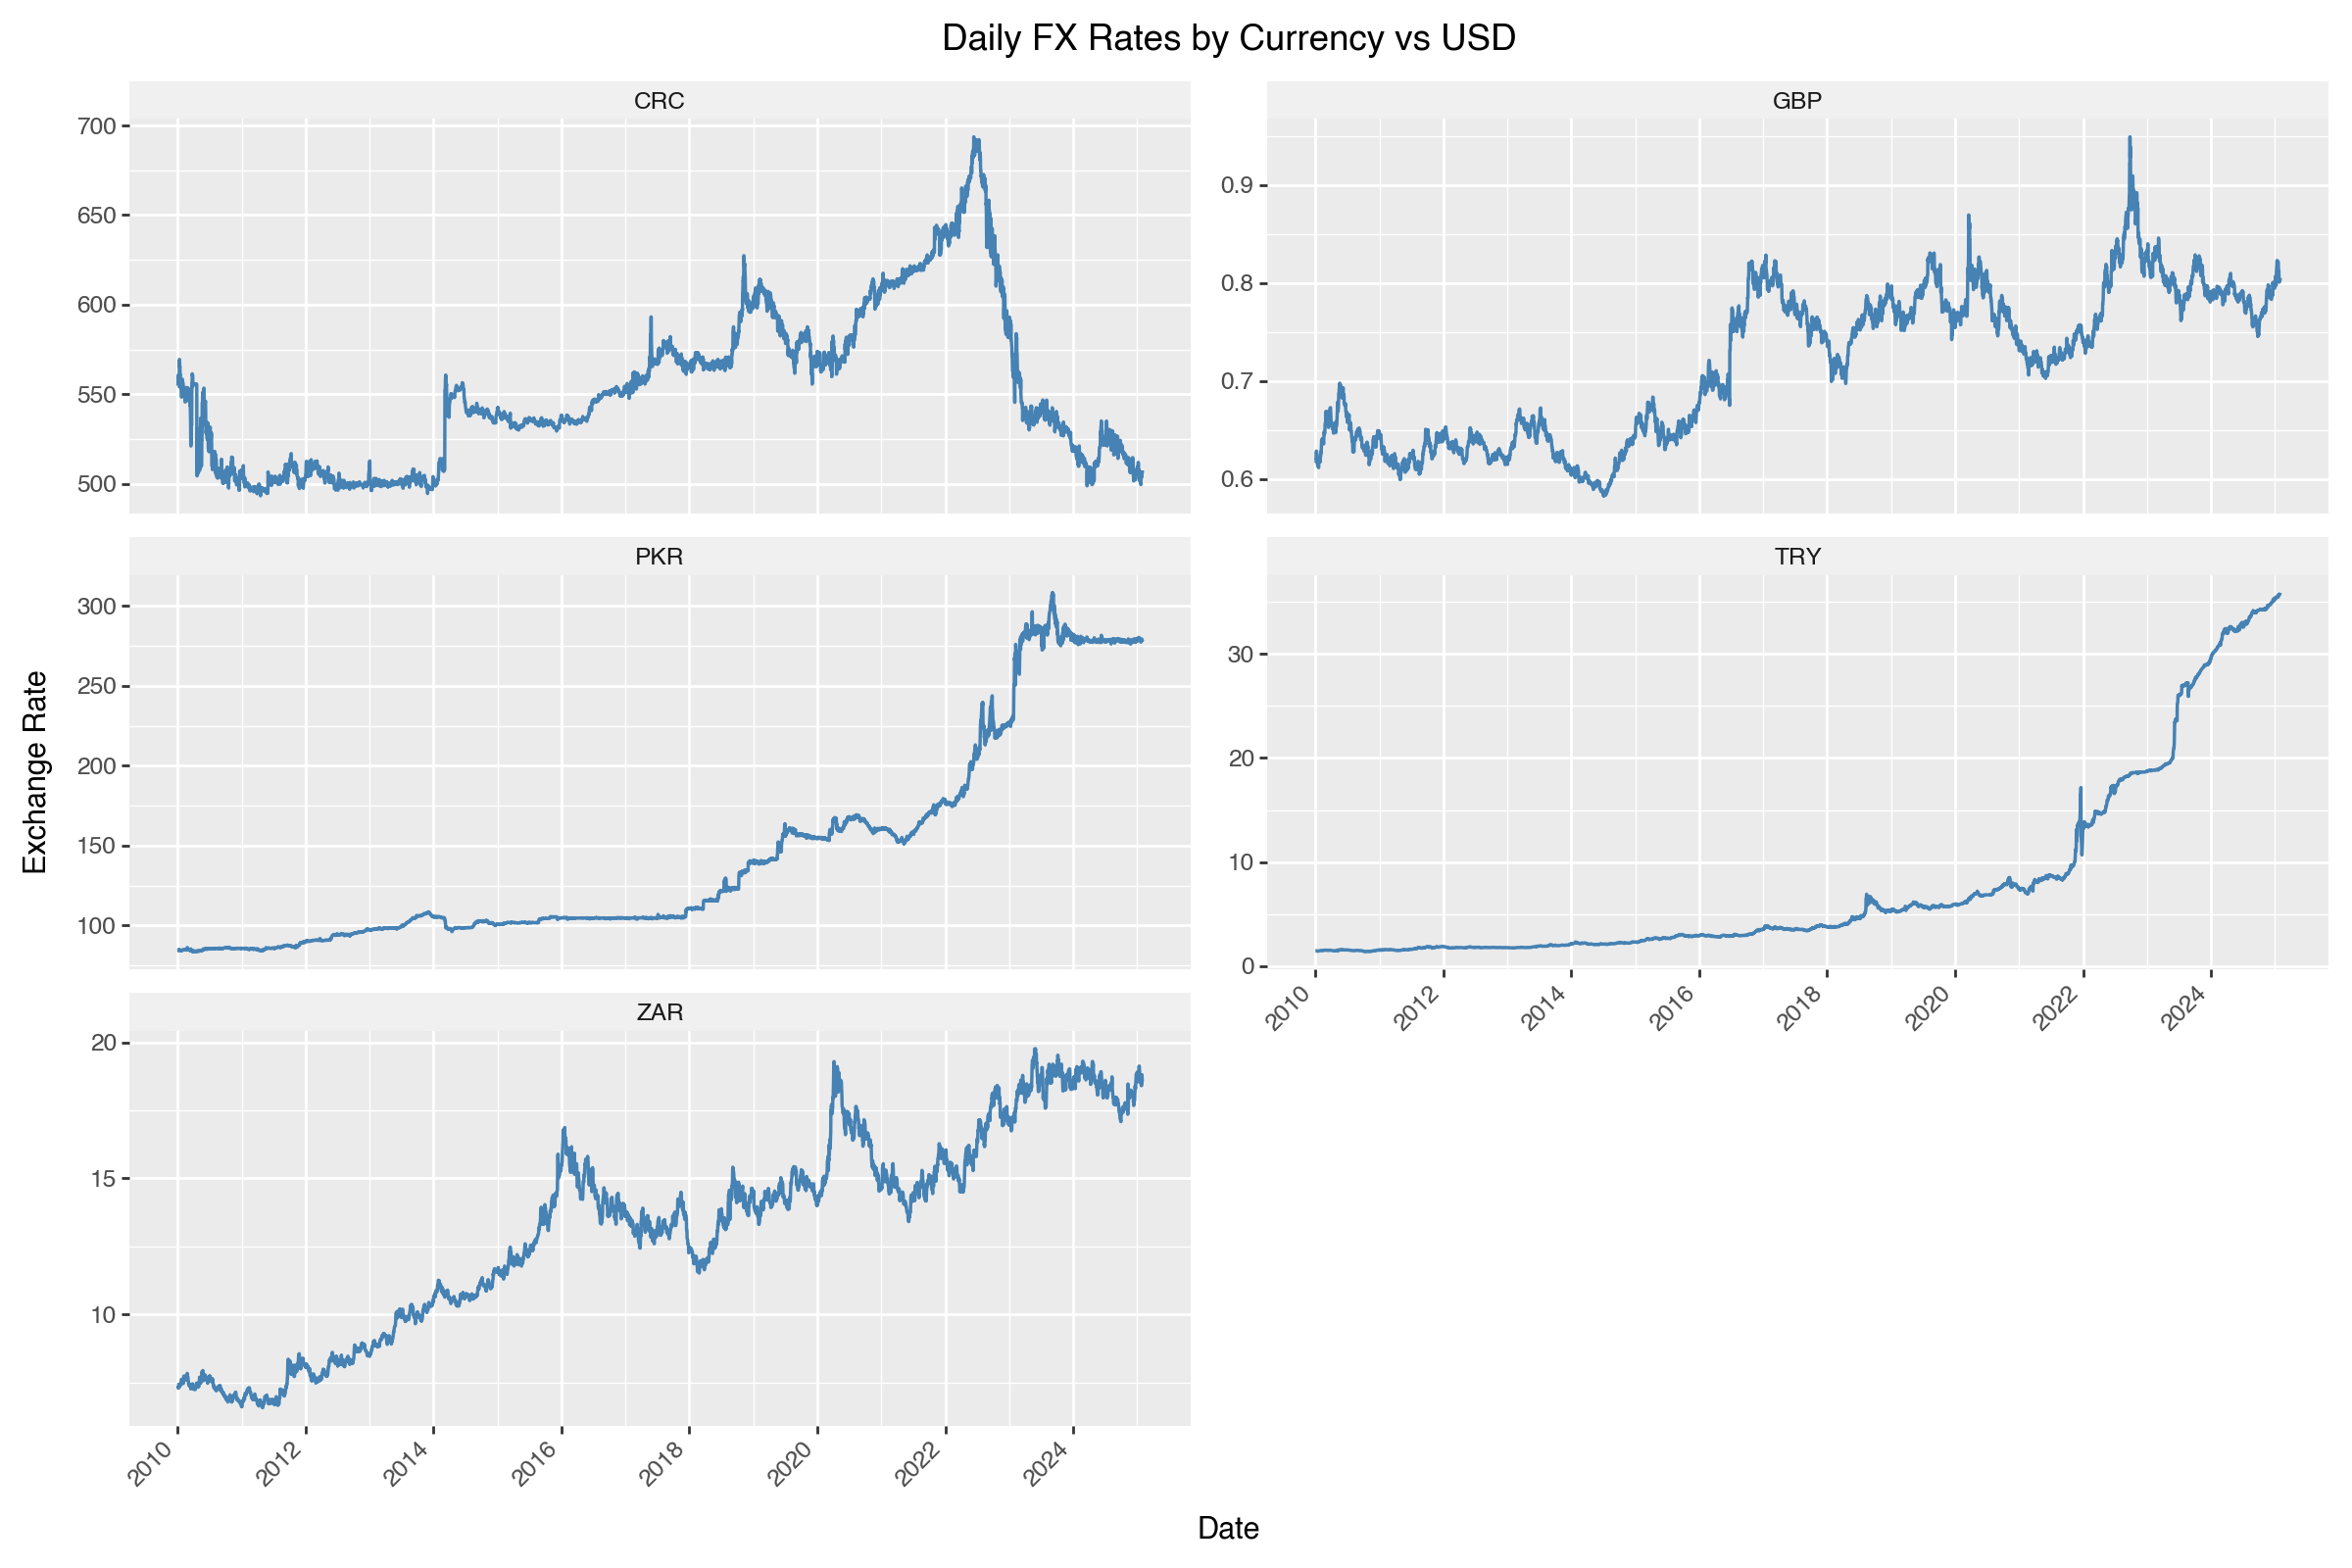

In [15]:
plot_fx_rates(filled_currencies)

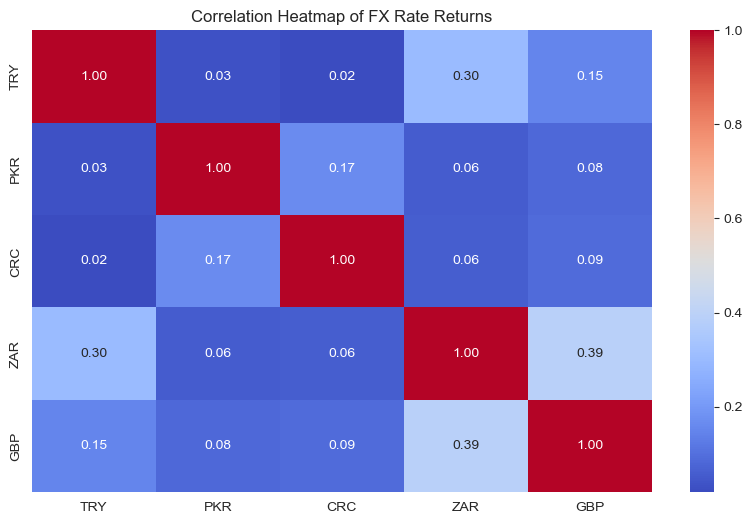

In [38]:
corr_matrix = pd.concat([df['rate'].pct_change().rename(df['code'].iloc[0]) for df in fx_dfs.values()], axis=1).corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=corr_matrix.columns, yticklabels=corr_matrix.index)
plt.title("Correlation Heatmap of FX Rate Returns")
plt.show()

1. **CRC (Costa Rican Colón)**
   - Sharp rise and fall (2022–2023) aligns with global inflation and Fed rate hikes, which affected emerging market currencies.
2. **GBP (British Pound)**
   - Fluctuations with noticeable dips correspond to Brexit (2016), UK fiscal crisis (2022, Liz Truss government), and global monetary tightening.
3. **PKR (Pakistani Rupee)**
   - Steady depreciation post-2018, accelerating in 2022–2023, matches Pakistan’s economic crisis, IMF bailouts, high inflation, and political instability.
4. **TRY (Turkish Lira)**
   - Stable until ~2018, then rapid devaluation from 2020 onward, coincides with Erdogan’s unorthodox rate cuts, 2021 currency crisis, and post-earthquake economic strain (2023).
5. **ZAR (South African Rand)**
   - Cyclical peaks and troughs likely tied to commodity price fluctuations (gold, minerals), 2020 COVID-19 crash, and 2022–2023 energy crisis (rolling blackouts).

- TRY and PKR show severe devaluations due to domestic policy issues and inflationary pressures.
- GBP and CRC remain relatively stable but reflect major economic shocks.
- ZAR moves cyclically, suggesting commodity dependence and external economic sensitivity.

changes in fx rates across currencies are not highly correlated, correlation observed could be due to overall global macro trends.

## Inferred Yeild curves
swap curve to zero curve

In [39]:
iyc_df = pd.read_csv('InferredYieldCurves_2025-02-04.tab', delimiter='\t', index_col='date')
iyc_df = iyc_df.drop(iyc_df.columns[0], axis=1)

In [40]:
try_iyc_df = iyc_df[iyc_df.shortname == 'Rep Turkey'] # Turkish Lira
pkr_iyc_df = iyc_df[iyc_df.shortname == 'Islamic Rep Pakistan'] # Pakistani Rupee
crc_iyc_df = iyc_df[iyc_df.shortname == 'Rep Costa Rica'] # Costa Rican Colón
zar_iyc_df = iyc_df[iyc_df.shortname == 'Rep South Africa'] # South African Rand

In [41]:
iyc_dfs = {'TRY': try_iyc_df, 'PKR': pkr_iyc_df, 'CRC': crc_iyc_df, 'ZAR': zar_iyc_df}
get_date_summary(iyc_dfs, col_name='shortname')

,Min Date,Max Date,Max Gap (Days),Max Gap Start,Max Gap End,Total Days
DataFrame,,,,,,
Rep Turkey,2010-01-04,2025-02-04,4,2024-06-13,2024-06-17,3935
Islamic Rep Pakistan,2010-01-04,2025-02-04,155,2024-04-02,2024-09-04,3696
Rep Costa Rica,2010-01-04,2025-02-04,6,2011-06-01,2011-06-07,3931
Rep South Africa,2010-01-04,2025-02-04,4,2024-06-13,2024-06-17,3935


In [42]:
filtered_iyc_dfs = {}
for k, df in iyc_dfs.items():
    mask = (df.index >= '2010-06-01') & (df.index <= '2024-03-31')
    filtered_iyc_dfs.update({k:df.loc[mask]})
get_date_summary(filtered_iyc_dfs, col_name='shortname')

,Min Date,Max Date,Max Gap (Days),Max Gap Start,Max Gap End,Total Days
DataFrame,,,,,,
Rep Turkey,2010-06-01,2024-03-29,3,2010-06-04,2010-06-07,3609
Islamic Rep Pakistan,2010-06-01,2024-03-29,31,2022-04-26,2022-05-27,3566
Rep Costa Rica,2010-06-01,2024-03-29,6,2011-06-01,2011-06-07,3605
Rep South Africa,2010-06-01,2024-03-29,3,2010-06-04,2010-06-07,3609


### PKR additional conditions

PKR has max gap of 155 days (2024-04-02 to 2024-09-04) and 120 days (2010-01-21 to 2010-05-21) while the rest of the currencies are relatively clean. So I will be slicing the data with end date of Mar 31, 2024.

Now PKR has max gap of 31 days between (2022-04-26 to 2022-05-27) which I am going to ignore for furthur calculations as we will have to slice the data to 2022 May which removes recent data. We will store these start and end dates and will not run our trading strategy between those days. Expect for these 31 days #NaNs is PKR is low.

In [20]:
pkr_start_date_ignore = '2022-04-26'
pkr_end_date_ignore = '2022-05-27'

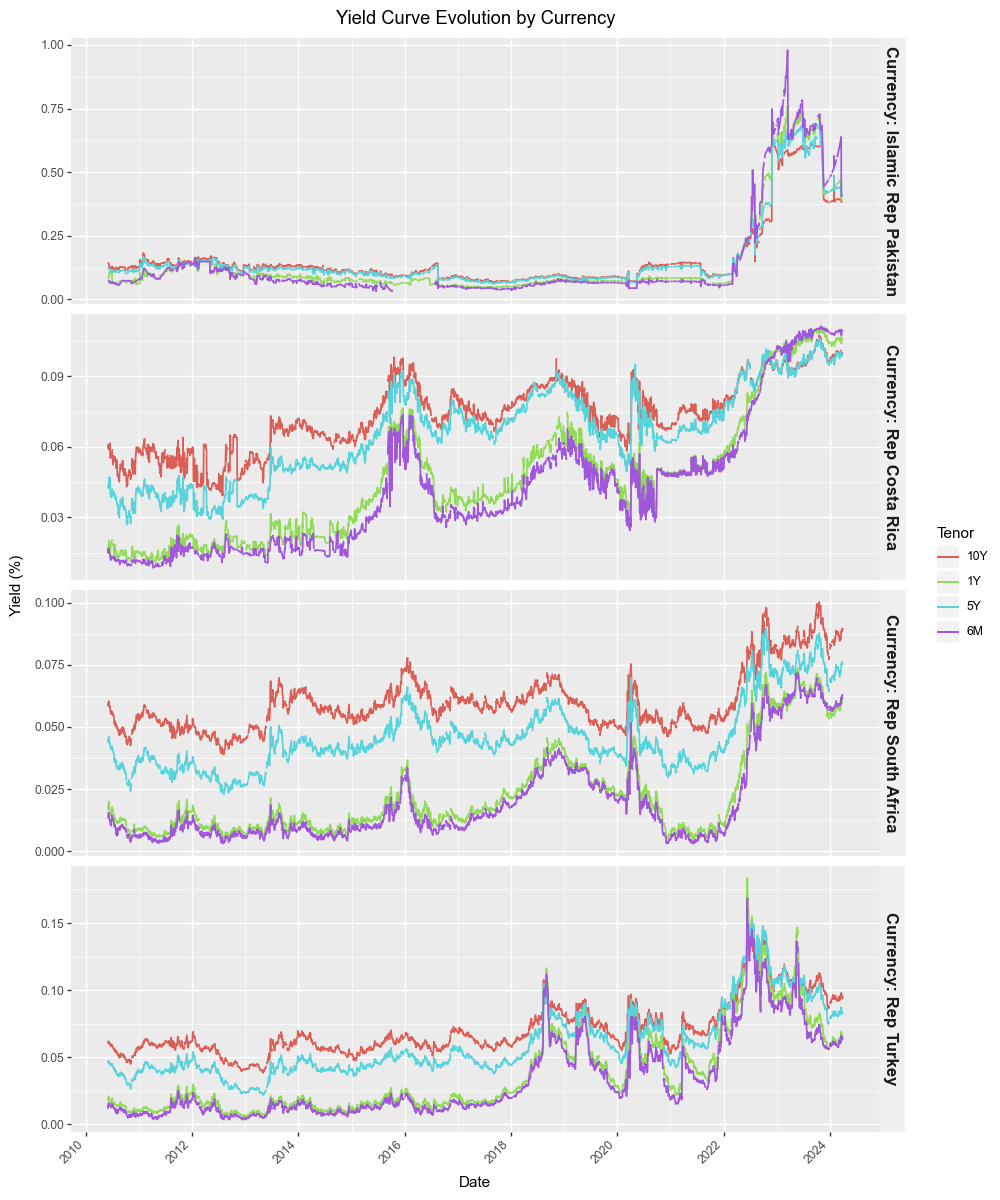

In [21]:
plot_yield_curves(filtered_iyc_dfs).draw()

Swap rates from given data as expected are highly auto correlated and across tenors follow a similar pattern.

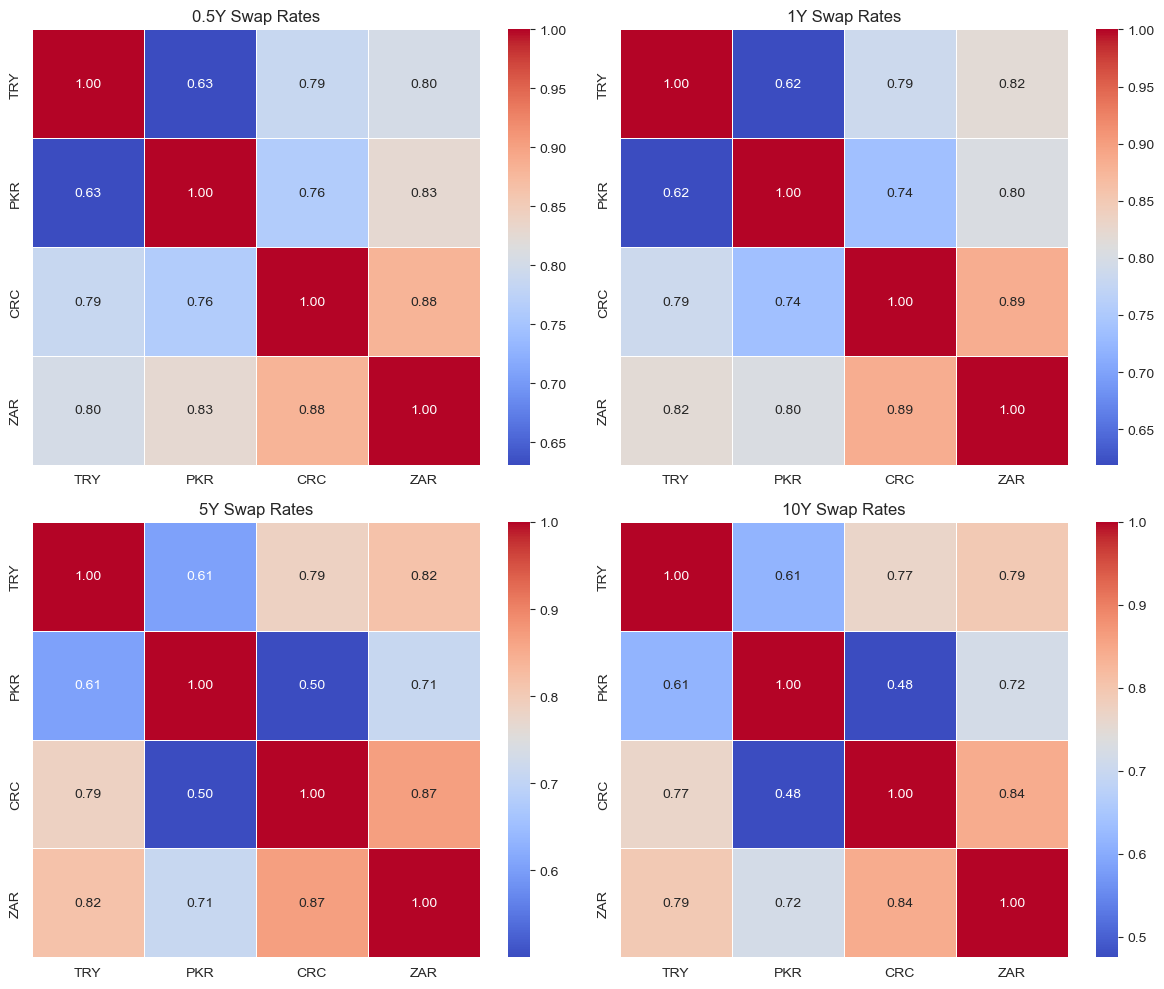

In [51]:
#pivoting and cleaning the dataset
processed_swap_dfs = process_swap_rates(filtered_iyc_dfs, min_date='2010-06-01', max_date='2024-03-31')
plot_swap_rate_correlation_subplots(processed_swap_dfs)

The correlations across tenors are high, consistent (ex: TRY/PKR - 0.63 (6 months), 0.62 (1 year), 0.61 (5 years), 0.61 (10 years)) and decreasing suggesting that short-term swap rates are more influenced by domestic monetary policy, while long-term rates reflect global macro trends (shared variation).

## Zero Curve

In [52]:
zero_curve_list = {k: compute_zcb_curve(v) for k, v in processed_swap_dfs.items()}

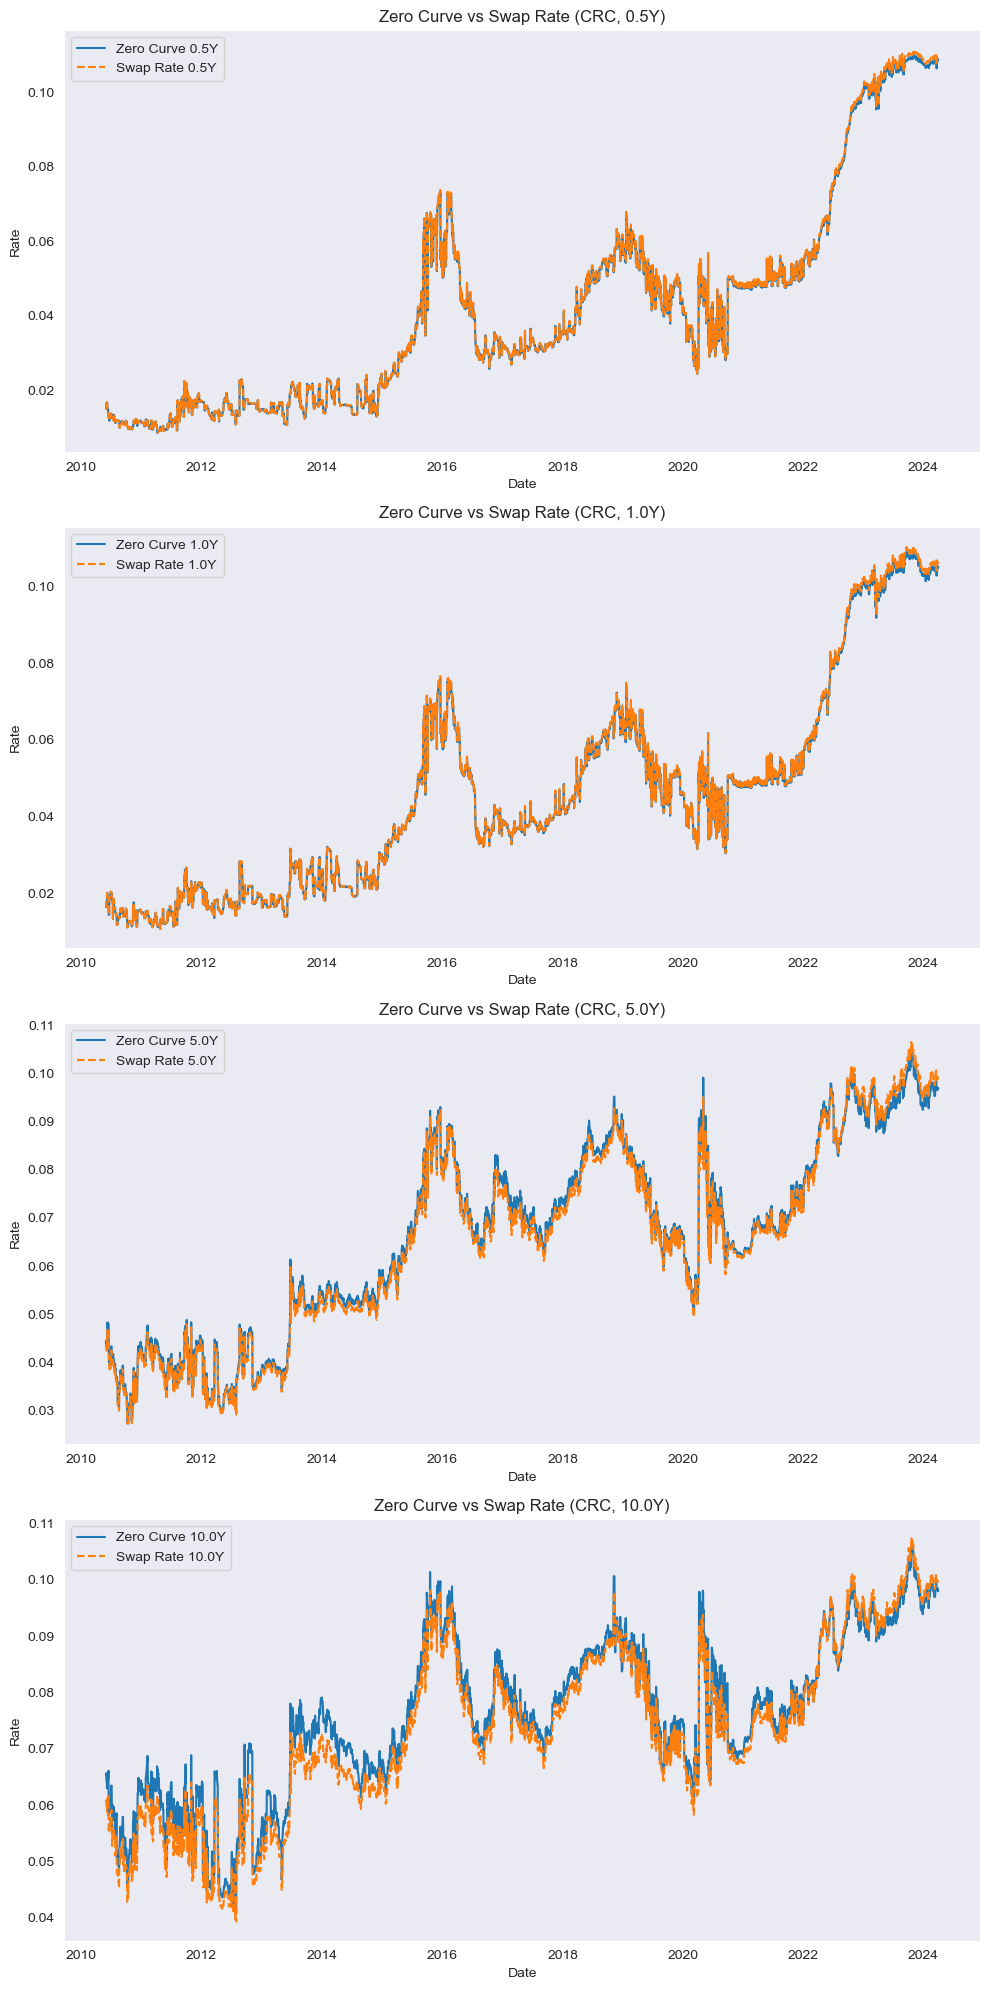

In [53]:
plot_zero_curve_vs_swap_rates_by_tenor('CRC', zero_curve_list, processed_swap_dfs)

Analyzing swap vs. zero rates for CRC to verify if they follow a similar trend as expected, and whether the difference becomes more pronounced with increasing tenor.

## OIS rate

In [58]:
ois_df = pd.read_csv('IUDSOIA  Bank of England  Database.csv').rename(columns={'Date': 'date'})
ois_df.columns.values[1] = 'rate'
ois_df['date'] = pd.to_datetime(ois_df['date'], format='%d %b %y')
ois_df.set_index('date', inplace=True)

In [59]:
ois_df['weekly rate with spread'] = (ois_df['rate']+0.5)/52
ois_df = ois_df.reindex(pd.date_range(start=ois_df.index.min(), end=ois_df.index.max(), freq='D')).ffill()

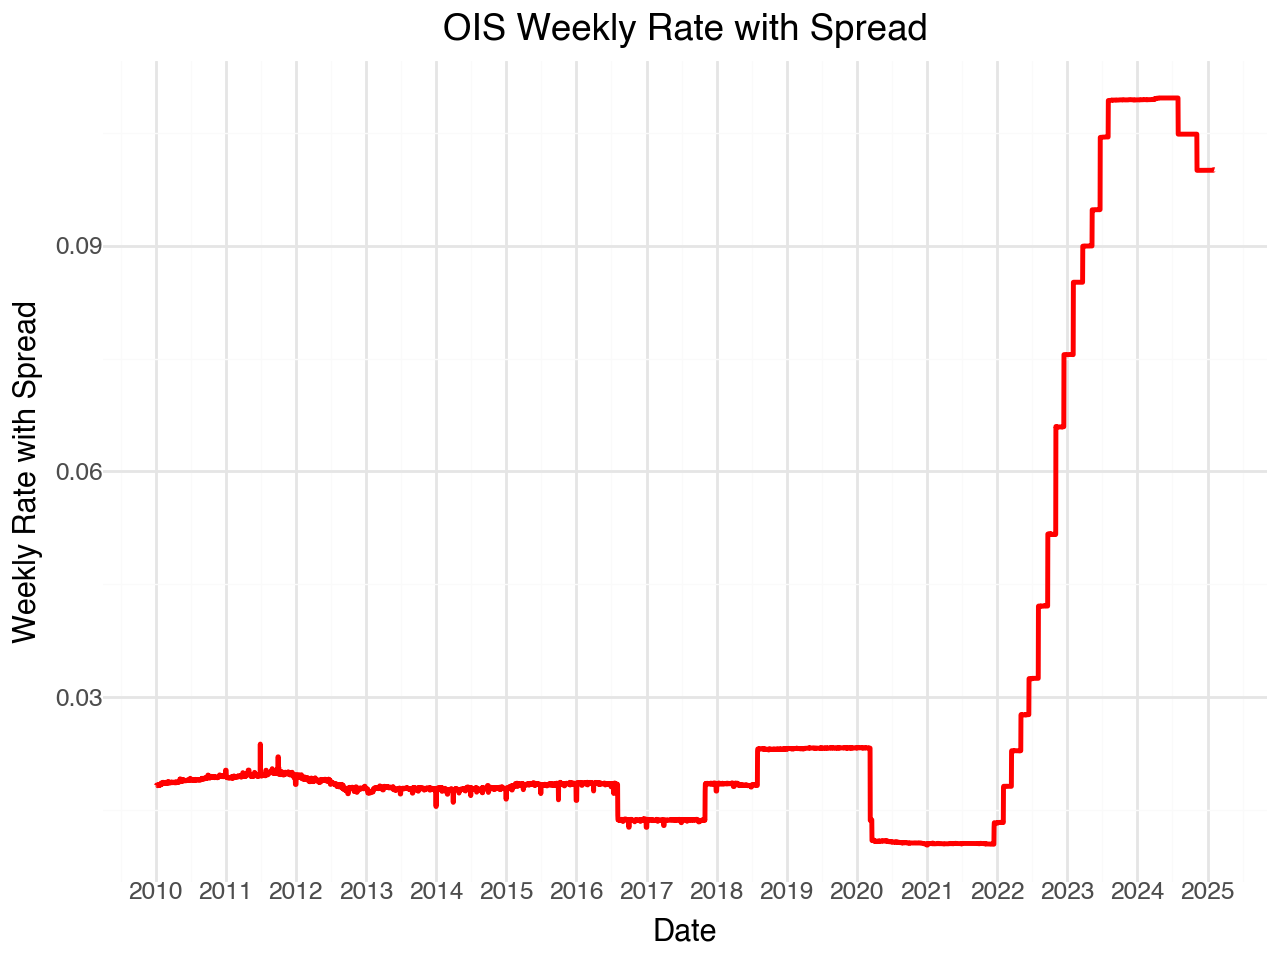

In [60]:
ois_long = ois_df[['weekly rate with spread']].copy()
ois_long['date'] = ois_long.index

p = (
    p9.ggplot(ois_long, p9.aes(x='date', y='weekly rate with spread'))
    + p9.geom_line(color='red', size=1)
    + p9.labs(title="OIS Weekly Rate with Spread", x="Date", y="Weekly Rate with Spread")
    + p9.theme_minimal()
    + p9.scale_x_datetime(date_labels='%Y', date_breaks='1 year'))
p


This pattern mirrors global central bank actions—rates were held low for years, followed by sharp hikes in response to inflation, and now a potential stabilization phase.

# FX Carry Strategy

In [117]:
def simulate_trading_strategy(
    gbp_usd_rates, foreign_usd_rates, gbp_interest_rates, zero_curve, swap_rates,
    start_date, end_date, pkr_start_date_ignore=pkr_start_date_ignore, pkr_end_date_ignore=pkr_end_date_ignore):

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    if pkr_start_date_ignore and pkr_end_date_ignore:
        pkr_start_date_ignore = pd.to_datetime(pkr_start_date_ignore)
        pkr_end_date_ignore = pd.to_datetime(pkr_end_date_ignore)

    current_date = start_date
    pnl_history = []
    next_week = current_date + pd.Timedelta(weeks=1)

    while next_week < end_date:
        if pkr_start_date_ignore and pkr_end_date_ignore and pkr_start_date_ignore <= current_date <= pkr_end_date_ignore:
            current_date, next_week = next_week, next_week + pd.Timedelta(weeks=1)
            continue  # Skip PKR ignore range

        # FX Rates
        gbp_to_usd_0 = gbp_usd_rates.at[current_date, "rate"]
        gbp_to_usd_1 = gbp_usd_rates.at[next_week, "rate"]
        foreign_to_usd_0 = foreign_usd_rates.at[current_date, "rate"]
        foreign_to_usd_1 = foreign_usd_rates.at[next_week, "rate"]

        # GBP Interest Rate (weekly OIS + 50bp)
        gbp_interest_rate = gbp_interest_rates.at[current_date, "weekly rate with spread"]/100

        # Get 5Y swap rate (used as the bond's coupon rate)
        bond_coupon_rate = swap_rates.at[current_date, 5]  # Already in decimal form

        # Get zero curves
        zero_rates_0 = zero_curve.loc[current_date]
        zero_rates_1 = zero_curve.loc[next_week]

        # Convert USD 10Mn to foreign currency
        notional = 10_000_000
        leverage = 0.8
        notional_fc = notional / foreign_to_usd_0

        # Compute bond price at entry and exit using bond_price function
        bond_price_entry = bond_price(zero_rates_0, bond_coupon_rate, 5)
        bond_price_exit = bond_price(zero_rates_1, bond_coupon_rate, 5)

        # Determine number of bonds such that total PV matches the notional_fc
        num_bonds = notional_fc / bond_price_entry

        # Compute Total PV at Entry (Foreign Currency & USD)
        initial_pv_fc = num_bonds * bond_price_entry
        initial_pv_usd = initial_pv_fc * foreign_to_usd_0

        # Compute Total PV at Exit (Foreign Currency & USD)
        final_pv_fc = num_bonds * bond_price_exit
        final_pv_usd = final_pv_fc * foreign_to_usd_1

        # Compute Bond Earnings (PnL from bond price movement)
        bond_earnings = final_pv_usd - initial_pv_usd

        # Interest paid on GBP borrowing (convert to USD at exit FX rate)
        borrowed_fc = leverage * notional / gbp_to_usd_0
        gbp_interest_payment = borrowed_fc * gbp_interest_rate * gbp_to_usd_1

        # Compute PnL
        pnl = bond_earnings - gbp_interest_payment

        # Store results, including bond earnings and borrowing costs
        pnl_history.append({
            "date": next_week,
            "pnl": pnl,
            "bond_earnings": bond_earnings,
            "gbp_interest_payment": gbp_interest_payment
        })

        # Move to next week
        current_date, next_week = next_week, next_week + pd.Timedelta(weeks=1)

    return pd.DataFrame(pnl_history).set_index("date")

In [118]:
def plot_pnl_components_matplotlib(pnl_df, currency):
    pnl_df = pnl_df.reset_index()
    pnl_df['cumulative_pnl'] = pnl_df['pnl'].cumsum()
    pnl_df['cumulative_bond_earnings'] = pnl_df['bond_earnings'].cumsum()
    pnl_df['cumulative_gbp_interest'] = pnl_df['gbp_interest_payment'].cumsum()
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(pnl_df['date'], pnl_df['cumulative_pnl'], label="Total PnL", color='red', linewidth=2)
    ax.plot(pnl_df['date'], pnl_df['cumulative_bond_earnings'], label="Bond Price Profit", color='blue', linestyle="dashed", linewidth=2)
    ax.plot(pnl_df['date'], pnl_df['cumulative_gbp_interest'], label="GBP Borrowing Cost", color='green', linestyle="dotted", linewidth=2)
    ax.set_title("Cumulative PnL with Components for {} (in USD)".format(currency))
    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative PnL (USD)")
    ax.legend()
    ax.grid(True)
    plt.show()

    # Plot weekly PnL
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(pnl_df['date'], pnl_df['pnl'], label="Weekly PnL", color='black', linewidth=1.5)
    ax.set_title("Weekly PnL Over Time")
    ax.set_xlabel("Date")
    ax.set_ylabel("Weekly PnL (USD)")
    ax.legend()
    ax.grid(True)
    plt.show()

    # Plot weekly Bond earnings
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(pnl_df['date'], pnl_df['bond_earnings'], label="Bond Earnings", linewidth=1.5)
    ax.set_title("Bond Earnings Over Time")
    ax.set_xlabel("Date")
    ax.set_ylabel("Bond Earning (USD)")
    ax.legend()
    ax.grid(True)
    plt.show()

    # Plot weekly GBP Interest Payment
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(pnl_df['date'], pnl_df['gbp_interest_payment'], label="GBP Interest Payment", linewidth=1.5)
    ax.set_title("GBP Interest Payment Over Time")
    ax.set_xlabel("Date")
    ax.set_ylabel("GBP Interest Payment (USD)")
    ax.legend()
    ax.grid(True)
    plt.show()

In [119]:
def compute_pnl_statistics(datasets):
    stats_dict = {}

    for name, df in datasets.items():
        for col in ['pnl', 'bond_earnings']:
            series = df[col].dropna()

            stats_dict[(col, name)] = {
                'Mean': f"{int(round(series.mean()))}",
                'Variance': f"{series.var():.2e}",
                'Skew': f"{series.skew():.2f}",
                'Kurtosis': f"{series.kurtosis():.2f}",
                'VaR 95%': f"{int(round(series.quantile(0.05)))}",
                'VaR 99%': f"{int(round(series.quantile(0.01)))}",
                'CVaR 95%': f"{int(round(series[series <= series.quantile(0.05)].mean()))}",
                'CVaR 99%': f"{int(round(series[series <= series.quantile(0.01)].mean()))}",
            }

    # Compute stats for 'gbp_interest_payment' only once (since it's the same across all currencies)
    gbp_interest_series = next(iter(datasets.values()))['gbp_interest_payment'].dropna()
    stats_dict[('gbp_interest_payment', 'ALL CURRENCIES')] = {
        'Mean': f"{int(round(gbp_interest_series.mean()))}",
        'Variance': f"{gbp_interest_series.var():.2e}",
        'Skew': f"{gbp_interest_series.skew():.2f}",
        'Kurtosis': f"{gbp_interest_series.kurtosis():.2f}",
        'VaR 95%': f"{int(round(gbp_interest_series.quantile(0.05)))}",
        'VaR 99%': f"{int(round(gbp_interest_series.quantile(0.01)))}",
        'CVaR 95%': f"{int(round(gbp_interest_series[gbp_interest_series <= gbp_interest_series.quantile(0.05)].mean()))}",
        'CVaR 99%': f"{int(round(gbp_interest_series[gbp_interest_series <= gbp_interest_series.quantile(0.01)].mean()))}",
    }

    stats_df = pd.DataFrame(stats_dict).T
    stats_df.index.names = ['Metric', 'Dataset']
    stats_df = stats_df.sort_index(level=0)

    return stats_df

In [120]:
start_date = '2010-06-02' #starting on wednesday as mentioned in homework
end_date = '2024-03-31'

##  Tukrish Lira

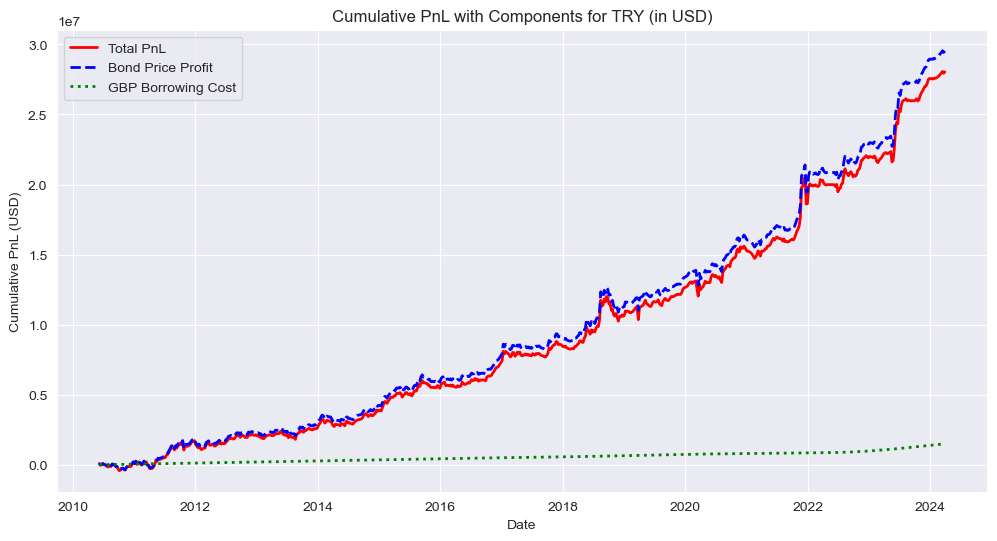

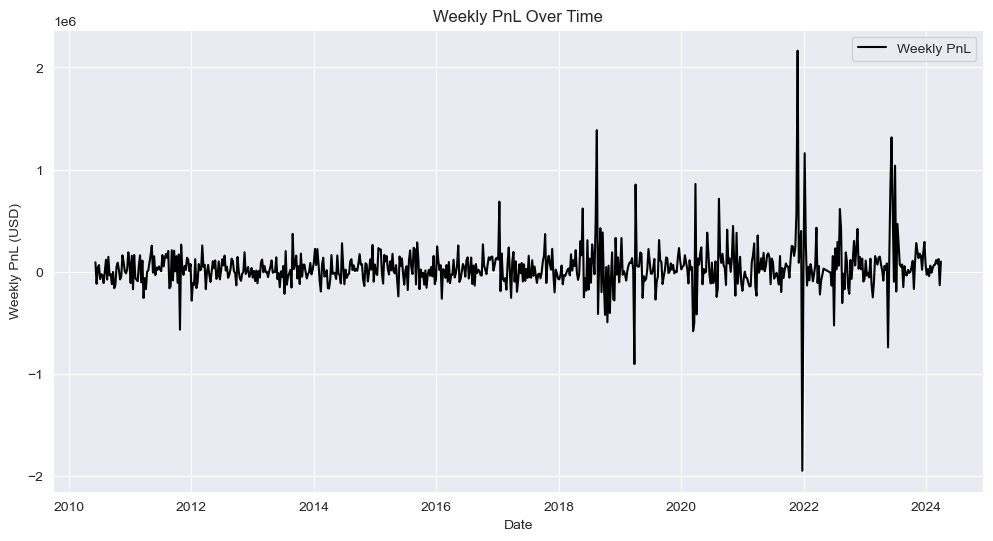

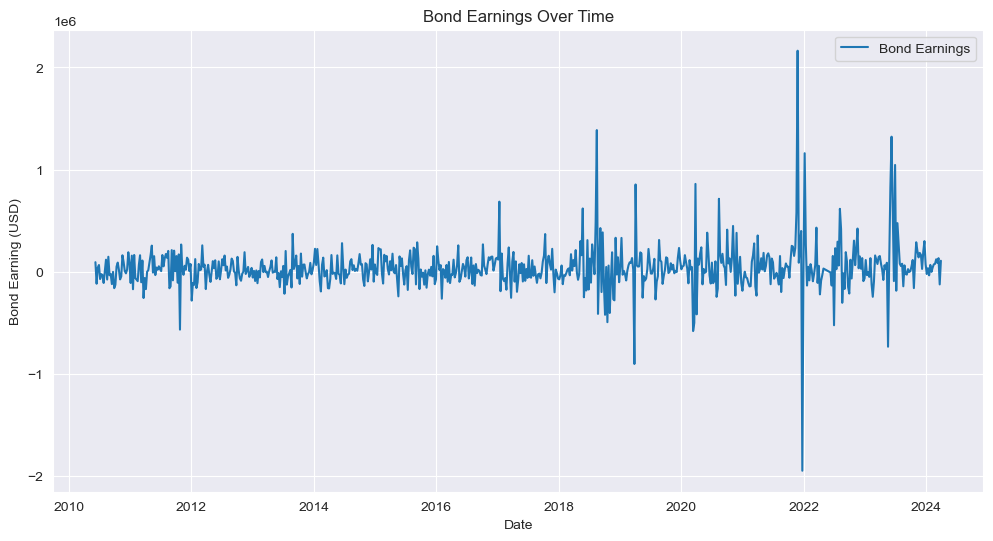

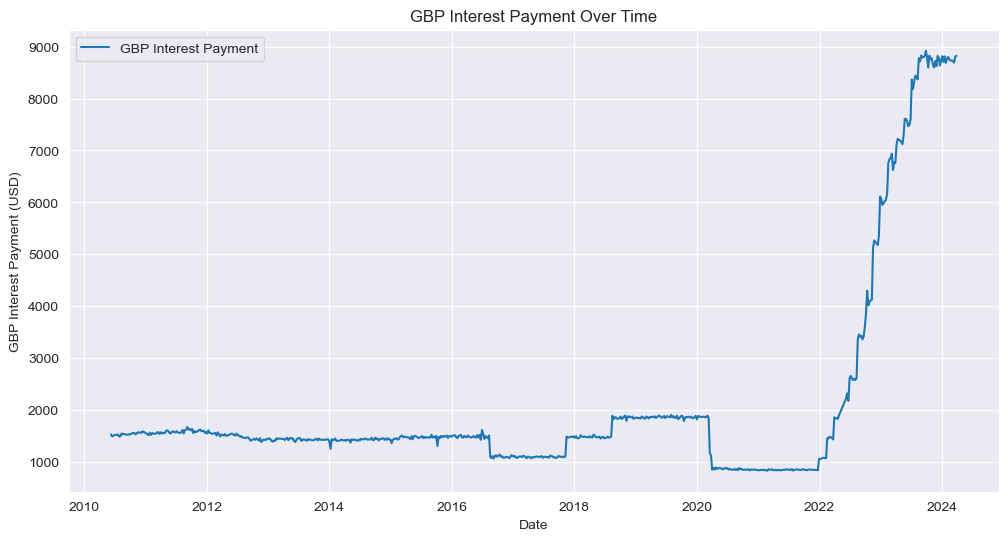

In [121]:
currency = 'TRY'
pnl_df_try = simulate_trading_strategy(
    gbp_usd_rates=fx_dfs['GBP'],
    foreign_usd_rates=fx_dfs[currency],
    gbp_interest_rates=ois_df,
    zero_curve=zero_curve_list[currency].iloc[:, :-1],
    start_date=start_date,
    end_date=end_date,
    swap_rates=processed_swap_dfs[currency]
)
plot_pnl_components_matplotlib(pnl_df_try, currency)

## Pakistani Rupee

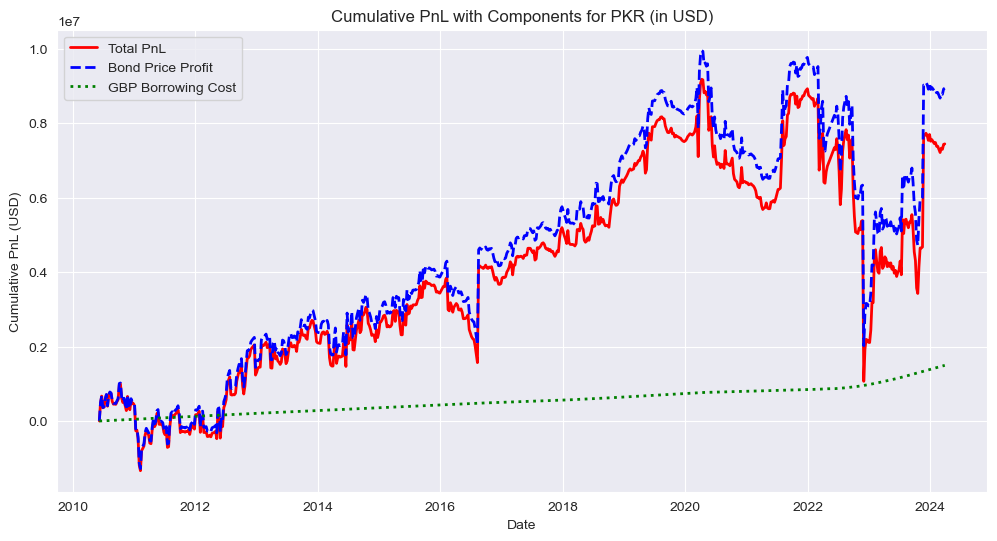

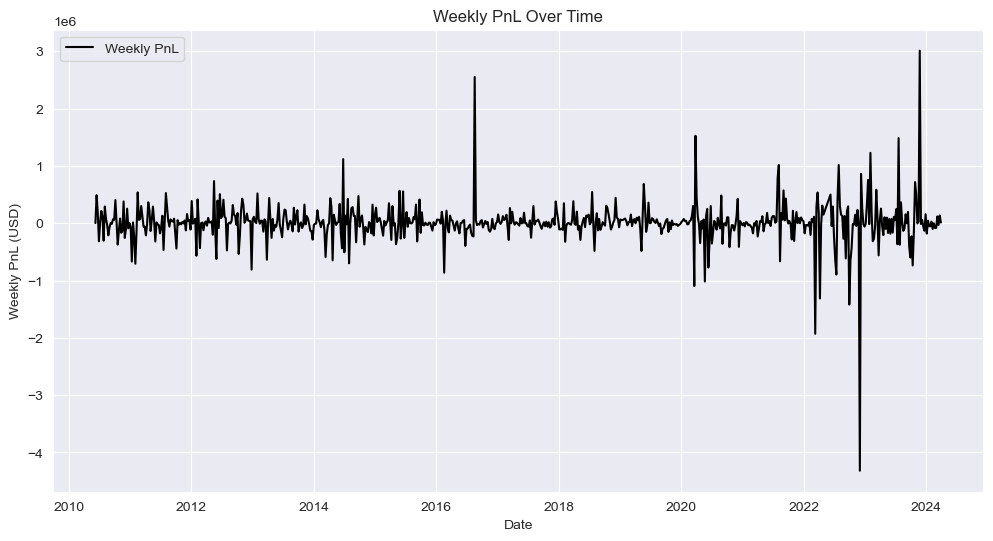

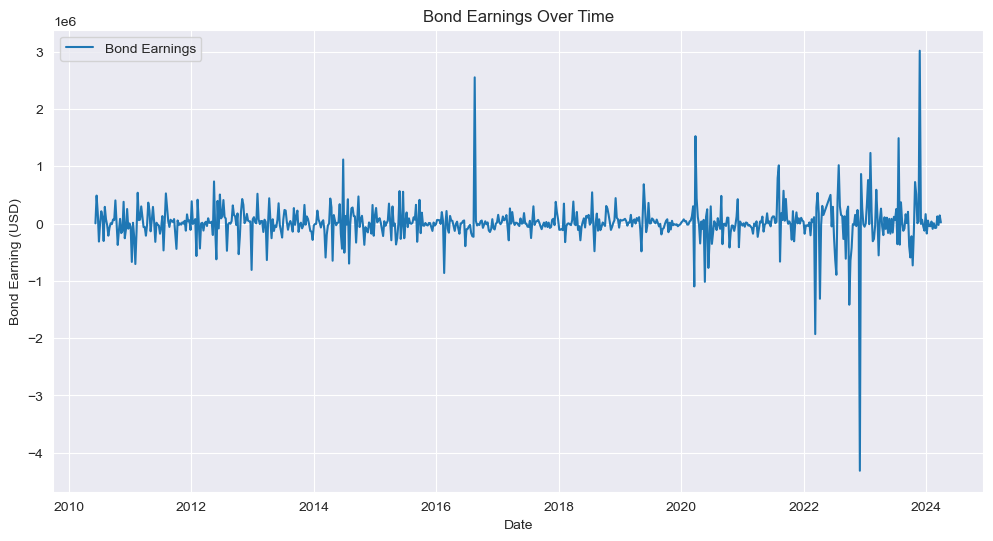

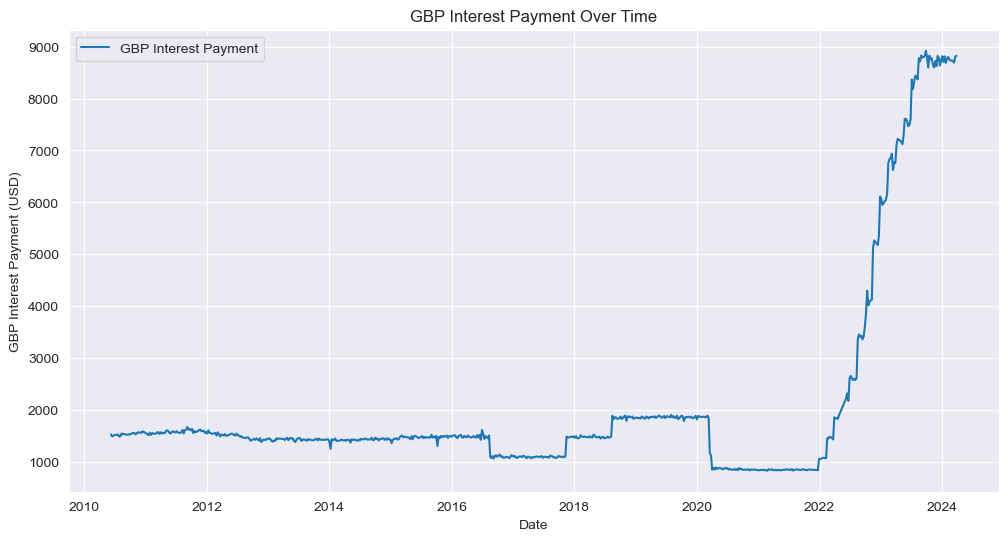

In [122]:
currency = 'PKR'
pnl_df_pkr = simulate_trading_strategy(
    gbp_usd_rates=fx_dfs['GBP'],
    foreign_usd_rates=fx_dfs[currency],
    gbp_interest_rates=ois_df,
    zero_curve=zero_curve_list[currency].iloc[:, :-1],
    start_date=start_date,
    end_date=end_date,
    swap_rates=processed_swap_dfs[currency]
)
plot_pnl_components_matplotlib(pnl_df_pkr, currency)

## Costa Rican Colon

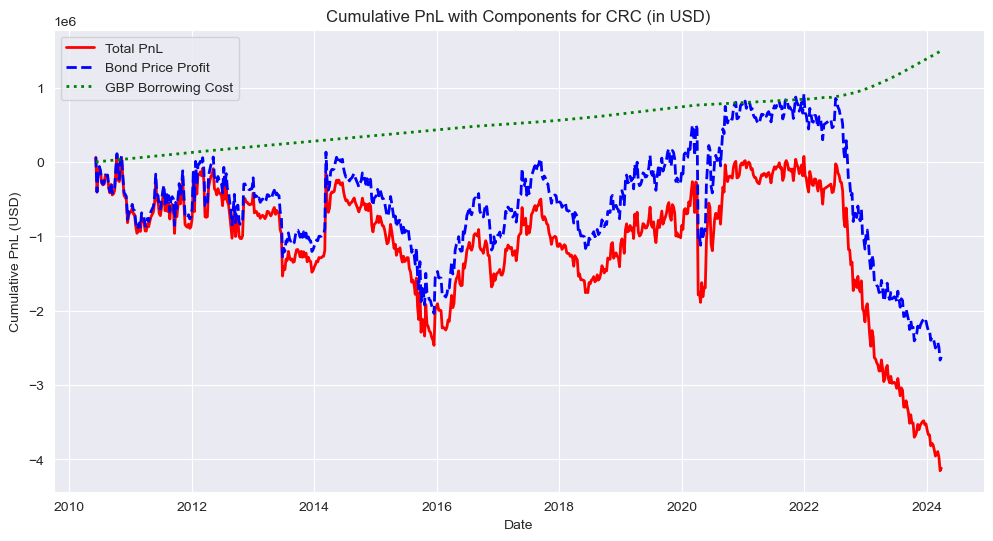

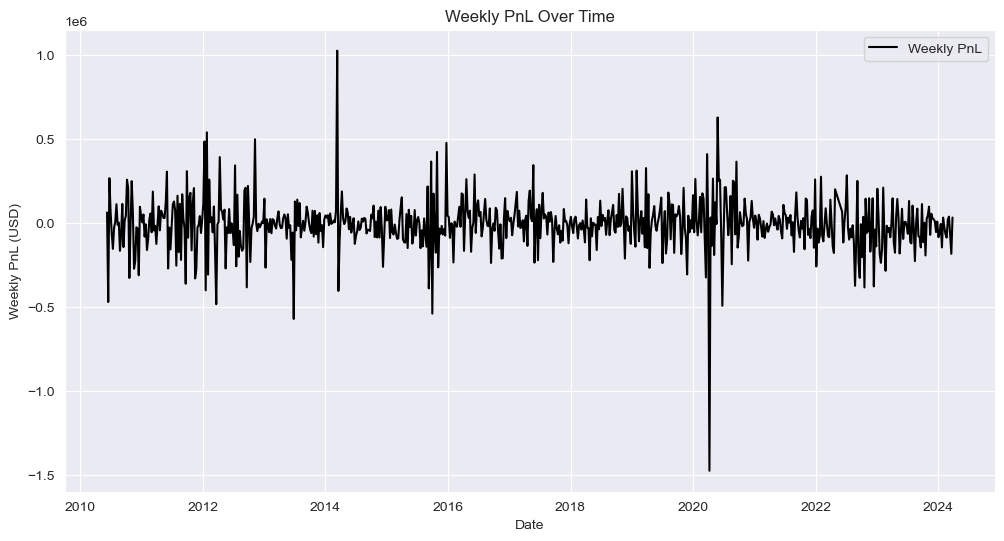

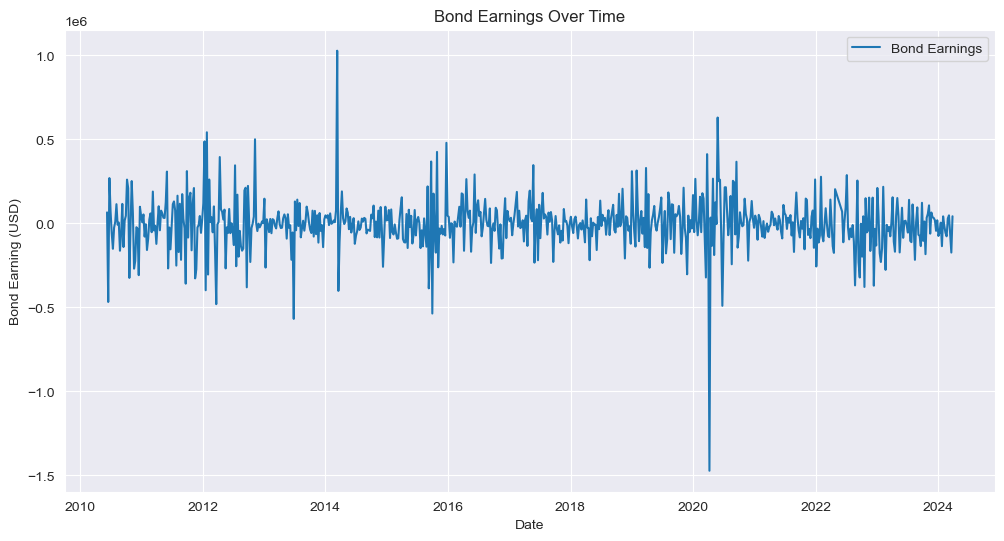

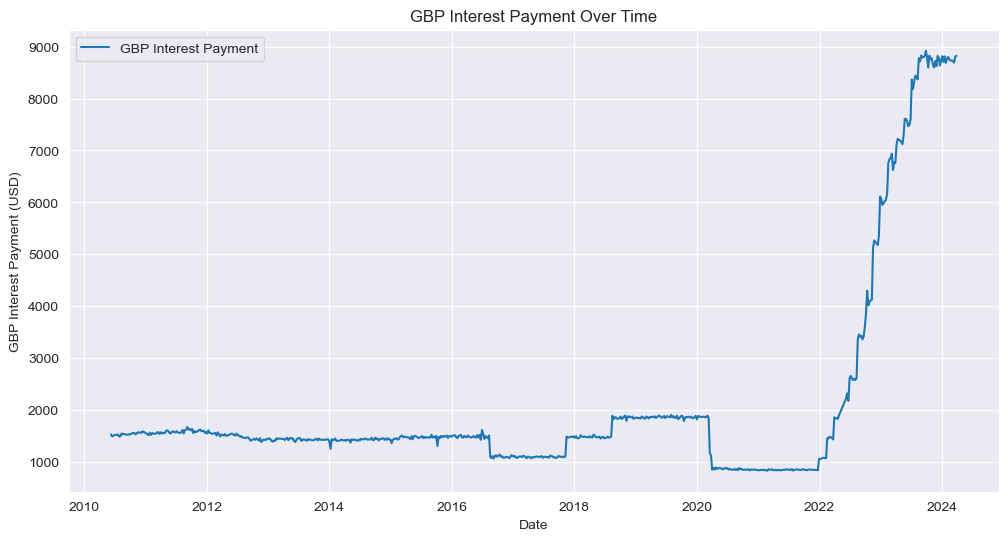

In [123]:
currency = 'CRC'
pnl_df_crc = simulate_trading_strategy(
    gbp_usd_rates=fx_dfs['GBP'],
    foreign_usd_rates=fx_dfs[currency],
    gbp_interest_rates=ois_df,
    zero_curve=zero_curve_list[currency].iloc[:, :-1],
    start_date=start_date,
    end_date=end_date,
    swap_rates=processed_swap_dfs[currency]
)
plot_pnl_components_matplotlib(pnl_df_crc, currency)

## South African Rand

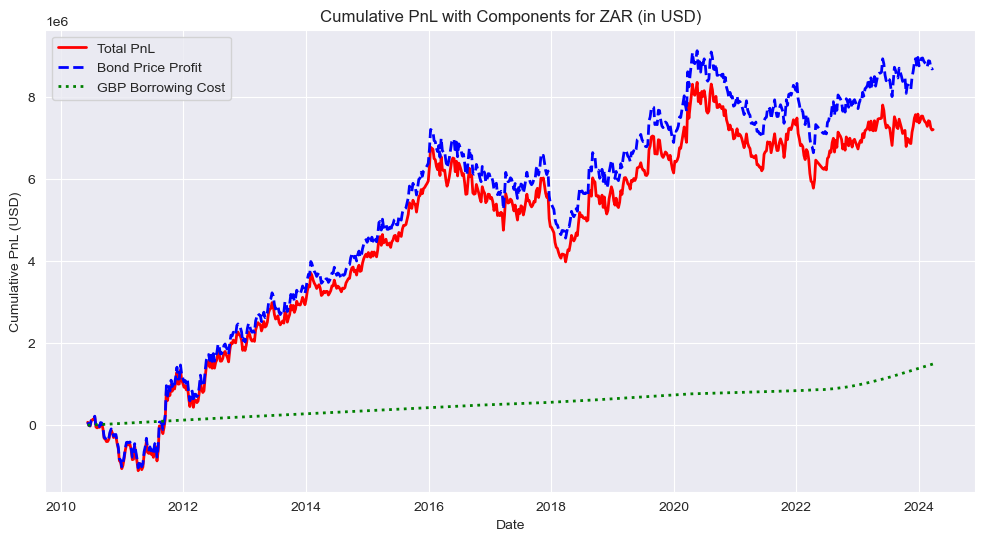

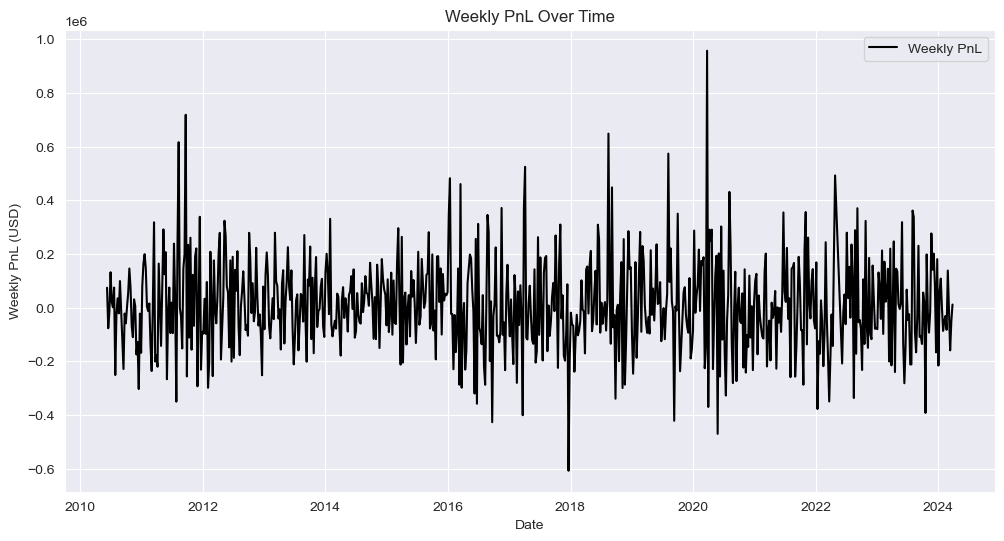

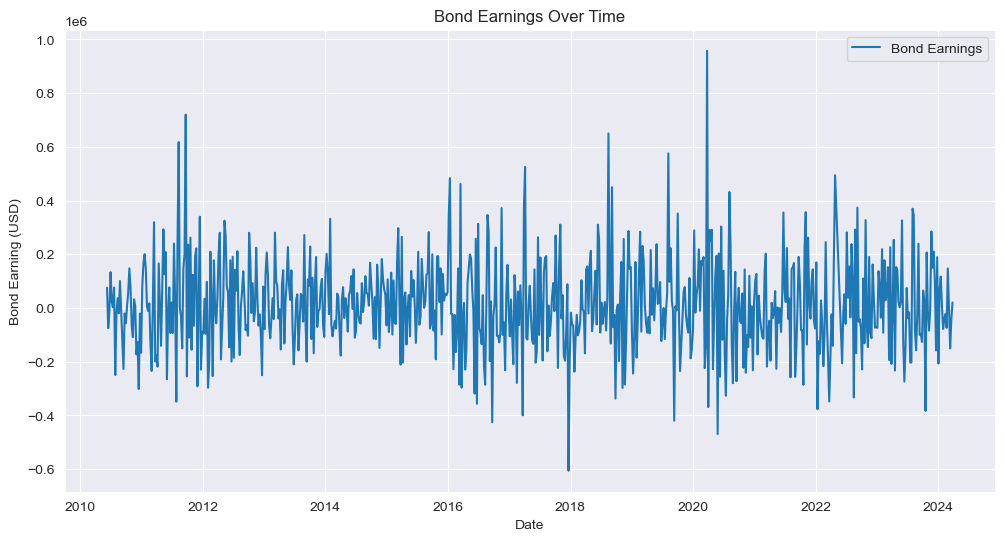

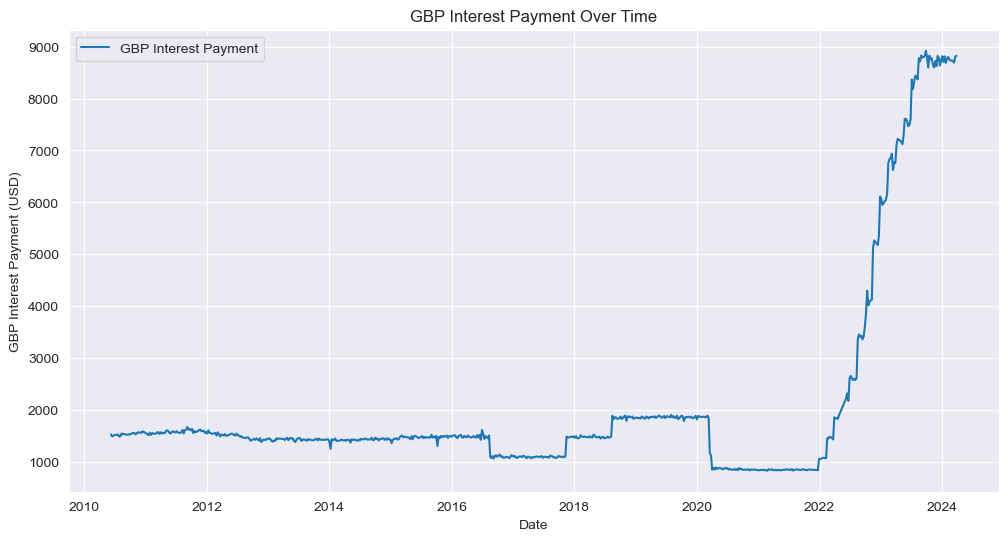

In [124]:
currency = 'ZAR'
pnl_df_zar = simulate_trading_strategy(
    gbp_usd_rates=fx_dfs['GBP'],
    foreign_usd_rates=fx_dfs[currency],
    gbp_interest_rates=ois_df,
    zero_curve=zero_curve_list[currency].iloc[:, :-1],
    start_date=start_date,
    end_date=end_date,
    swap_rates=processed_swap_dfs[currency]
)
plot_pnl_components_matplotlib(pnl_df, currency)

In [125]:
stats_df = compute_pnl_statistics({'TRY': pnl_df_try, 'PKR': pnl_df_pkr, 'CRC': pnl_df_crc, 'ZAR': pnl_df_zar})
display(stats_df)

Mean  Variance   Skew Kurtosis  VaR 95%  \
Metric               Dataset                                                    
bond_earnings        CRC             -3660  2.37e+10  -0.75    15.18  -233890   
                     PKR             12488  1.22e+11  -1.41    46.46  -412798   
                     TRY             41252  4.71e+10   1.28    28.12  -185073   
                     ZAR             12163  2.95e+10   0.50     1.87  -245415   
gbp_interest_payment ALL CURRENCIES   2090  3.89e+06   2.60     5.45      846   
pnl                  CRC             -5751  2.38e+10  -0.74    15.11  -235746   
                     PKR             10398  1.22e+11  -1.42    46.51  -413650   
                     TRY             39162  4.71e+10   1.28    28.17  -190060   
                     ZAR             10072  2.95e+10   0.51     1.88  -247178   

                                     VaR 99% CVaR 95%  CVaR 99%  
Metric               Dataset                                     
bond_earnings        CRC             -396015  -365073   -601802  
                     PKR             -854081  -807720  -1604750  
                     TRY             -480685  -376205   -778882  
                     ZAR             -367113  -321981   -431012  
gbp_interest_payment ALL CURRENCIES      835      840       833  
pnl                  CRC             -397558  -366957   -603134  
                     PKR             -855578  -810122  -1607037  
                     TRY             -482532  -378186   -781258  
                     ZAR             -368047  -323734   -433149

In [126]:
compute_correlation = lambda df1, col1, df2, col2: df1[[col1]].merge(df2[[col2]], left_index=True, right_index=True, how='inner').corr().iloc[0, 1]
correlation = compute_correlation(ois_df, 'rate', pnl_df_try, 'gbp_interest_payment')
print("Correlation:", correlation)

Correlation: 0.998881761874466


## Conclusions
**GBP interest payment** : would be same for all currencies as we are borrowing 80% of $10Mn. Its pattern closely matches OIS rate with correlation of 0.9989, with minute differences due to 50bps spread and changing fx rates of GBP vs USD (so fx rate influence on interest payment is almost nothing)

1. PKR is the Riskiest Currency
   - Highest variance (~1.22e+11)** and extreme kurtosis (46.5) suggest large swings in returns, making it highly volatile.
   - Deep tail risk (VaR 99%: ~-1.6M, CVaR 99%: ~-1.6M) indicates severe losses during extreme market events.

2. TRY Shows High Tail Risk Too
   - Kurtosis (28.1) suggests fat tails, meaning occasional extreme losses.
   - Negative skew confirms that losses tend to be larger than gains.

3. ZAR is the Least Risky
   - Lower variance (~2.95e+10) and minimal kurtosis (1.87) indicate a more stable return profile.
   - Balanced skew (~0.5) suggests no strong bias towards gains or losses.

4. CRC is Moderately Risky
   - Variance (~2.37e+10) is lower than PKR and TRY, but negative skew (-0.75) means losses dominate gains.
   - Moderate kurtosis (15.1) still indicates occasional large moves.

Diversifying away from PKR and TRY or implementing risk management strategies (stop losses, hedging) would improve risk-adjusted returns**. 🚀

## Fama-French Factors analysis

In [130]:
def clean_data(df, start_date, end_date, tickers=None, format=None):
    if format is None:
        df['date'] = pd.to_datetime(df['date'])
    else:
        df['date'] = pd.to_datetime(df['date'], format=format)
    filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date) & (df['ticker'].isin(tickers) if tickers is not None else True)]
    filtered_df=filtered_df.sort_values(by='date').reset_index(drop=True).set_index('date')
    return filtered_df

def analyze_pnl_vs_fama_french(pnl_dfs, ff5_df):
    pnl_pct_df = pd.DataFrame({currency: df['pnl'].pct_change().dropna() for currency, df in pnl_dfs.items()}).dropna()
    ff5_df['Market_Return'] = ff5_df['Mkt-RF'] + ff5_df['RF']
    merged_df = pnl_pct_df.join(ff5_df[['Market_Return']], how='inner').dropna()
    correlation_matrix = merged_df.corr()
    return correlation_matrix

In [131]:
ff5 = pd.read_csv(folder_path+'/F-F_Research_Data_5_Factors_2x3_daily.CSV', skiprows=3)
ff5.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
ff5 = ff5[['date', 'SMB', 'HML', 'RF', 'Mkt-RF']]
ff5 = clean_data(ff5, start_date, end_date, format='%Y%m%d')

In [132]:
ff5.head()

,SMB,HML,RF,Mkt-RF
date,,,,
2010-06-02,0.27,0.41,0.001,2.63
2010-06-03,0.66,-0.27,0.001,0.54
2010-06-04,-1.30,-0.67,0.001,-3.62
2010-06-07,-1.19,-1.01,0.001,-1.52
2010-06-08,-1.38,0.11,0.001,0.91


In [133]:
correlation_matrix = analyze_pnl_vs_fama_french({'TRY': pnl_df_try, 'PKR': pnl_df_pkr, 'CRC': pnl_df_crc, 'ZAR': pnl_df_zar}, ff5)
display(correlation_matrix)

,TRY,PKR,CRC,ZAR,Market_Return
TRY,1.000000,-0.001674,0.003323,0.003532,-0.031230
PKR,-0.001674,1.000000,-0.000683,-0.002114,0.002258
CRC,0.003323,-0.000683,1.000000,-0.000589,0.083278
ZAR,0.003532,-0.002114,-0.000589,1.000000,-0.032218
Market_Return,-0.031230,0.002258,0.083278,-0.032218,1.000000


The correlation matrix shows weak relationships between currency PnL changes and market returns. TRY and ZAR have slightly negative correlations with Market_Return (-0.031 and -0.032), suggesting minor inverse relationships. CRC has a small positive correlation (0.083), indicating it moves somewhat with the market. PKR shows almost no correlation (0.002), meaning its returns are largely independent. The low correlations suggest carry trade returns are not strongly linked to equity market moves, which aligns with the idea that currency strategies can provide diversification.